# Comparación Equitativa de Agentes en Blotto con Hiperparámetros Variados

Este cuaderno lleva a cabo una comparación completa entre distintos tipos de agentes en el juego Blotto (S=10, N=5), garantizando una evaluación equitativa mediante:

1. **Entrenamiento uniforme**: todos los agentes entrenan con la misma cantidad de episodios.
2. **Variedad de configuraciones**: cada tipo de agente se prueba con diferentes hiperparámetros.
3. **Evaluación exhaustiva**: cada agente se enfrenta a todos los demás.
4. **Análisis detallado**: visualizamos los resultados para identificar qué algoritmos y configuraciones funcionan mejor.

**Nota sobre Blotto**: En este juego, cada jugador debe distribuir S=10 soldados en N=5 campos de batalla. El ganador de cada campo es quien asigna más soldados, y gana el juego quien vence en más campos de batalla.

## Hiperparámetros a evaluar para cada tipo de agente

### Fictitious Play (FP)
- **FP_default**: configuración estándar sin sesgos iniciales.
- **FP_biased**: configuración con sesgo inicial hacia ciertas distribuciones de soldados.

### Regret Matching (RM)
- **RM_default**: política inicial uniforme.
- **RM_biased**: política inicial sesgada hacia cierta estrategia.

### Q-Learning Independiente (IQL)
- **IQL_default**: α=0.1, ε=0.1 (exploración equilibrada).
- **IQL_explore**: α=0.2, ε=0.3 (mayor exploración).
- **IQL_exploit**: α=0.05, ε=0.05 (mayor explotación).

### Joint-Action Learning con Modelado de Agente (JAL-AM)
- **JALAM_default**: α=0.1, ε=0.1 (configuración balanceada).
- **JALAM_explore**: α=0.2, ε=0.3 (mayor exploración).
- **JALAM_exploit**: α=0.05, ε=0.05 (mayor explotación).

## 1. Importaciones y configuración del entorno

Importamos las librerías necesarias y preparamos el entorno para el juego.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

# Add project root to sys.path to allow importing custom modules
module_path = os.path.abspath(os.path.join('..', 'Simultaneous Games')) # Adjust if notebook is in a different subfolder
if module_path not in sys.path:
    sys.path.append(module_path)

from games.blotto import Blotto
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JointActionLearningAgentModellingAgent
from agents.random_agent import RandomAgent
from base.game import SimultaneousGame, AgentID, ActionDict

## 2. Carga del entorno de juego Blotto (S=10, N=5)

In [2]:
# Crear un juego Blotto con S=10 soldados y N=5 campos de batalla
game = Blotto(S=10, N=5)

print("Blotto game loaded.")
print("Agents:", game.agents)
print("Action spaces:", game.action_spaces)

# Calcular número de acciones posibles para verificar la complejidad
num_actions = game.action_spaces[game.agents[0]].n
print(f"Number of possible actions (distributions of soldiers): {num_actions}")

# Mostrar algunas distribuciones posibles como ejemplo
print("\nEjemplos de distribuciones posibles de soldados:")
for i in range(min(5, num_actions)):
    print(f"Acción {i}: {game._moves[i]}")

Blotto game loaded.
Agents: ['agent_0', 'agent_1']
Action spaces: {'agent_0': Discrete(7), 'agent_1': Discrete(7)}
Number of possible actions (distributions of soldiers): 7

Ejemplos de distribuciones posibles de soldados:
Acción 0: [1, 1, 1, 1, 6]
Acción 1: [1, 1, 1, 2, 5]
Acción 2: [1, 1, 1, 3, 4]
Acción 3: [1, 1, 2, 2, 4]
Acción 4: [1, 1, 2, 3, 3]


## 3. Funciones auxiliares para cargar agentes entrenados

Definimos funciones que recuperan el estado guardado de los agentes entrenados en archivos `.pkl`.

In [3]:
def load_fp_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = FictitiousPlay(game=game_instance, agent=agent_id)
    counts_path = os.path.join('fp_trainings', game_name, f'agent_{agent_idx}_fp_counts.pkl')
    if os.path.exists(counts_path):
        with open(counts_path, 'rb') as f:
            loaded_counts = pickle.load(f)
            # FP agent's __init__ initializes self.count and self.learned_policy
            # We need to correctly re-assign the loaded counts and update the policy
            agent.count = loaded_counts
            for ag, ct_array in agent.count.items():
                sum_counts = np.sum(ct_array)
                if sum_counts == 0:
                    agent.learned_policy[ag] = np.ones(game_instance.action_spaces[ag].n) / game_instance.action_spaces[ag].n
                else:
                    agent.learned_policy[ag] = ct_array / sum_counts
        print(f"Loaded Fictitious Play agent {agent_id} for {game_name} from {counts_path}")
    else:
        print(f"Warning: No saved counts found for FP agent {agent_id} at {counts_path}. Using fresh agent.")
    return agent

def load_rm_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = RegretMatching(game=game_instance, agent=agent_id)
    policy_path = os.path.join('rm_trainings', game_name, f'agent_{agent_idx}_rm_policy.pkl')
    if os.path.exists(policy_path):
        with open(policy_path, 'rb') as f:
            # RM saves the learned_policy directly
            agent.learned_policy = pickle.load(f)
        print(f"Loaded Regret Matching agent {agent_id} for {game_name} from {policy_path}")
    else:
        print(f"Warning: No saved policy found for RM agent {agent_id} at {policy_path}. Using fresh agent.")
    return agent

def load_iql_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int, config: IQLAgentConfig = None):
    if config is None:
        config = IQLAgentConfig(epsilon=0.0) # Set epsilon to 0 for evaluation (greedy policy)
    agent = IQLAgent(game=game_instance, agent=agent_id, config=config)
    q_table_path = os.path.join('iql_trainings', game_name, f'agent_{agent_idx}_q_table.pkl')
    if os.path.exists(q_table_path):
        with open(q_table_path, 'rb') as f:
            agent.Q = pickle.load(f)
        print(f"Loaded IQL agent {agent_id} for {game_name} from {q_table_path}")
    else:
        print(f"Warning: No saved Q-table found for IQL agent {agent_id} at {q_table_path}. Using fresh agent.")
    agent.epsilon = 0 # Ensure greedy policy for evaluation
    return agent

def load_jalam_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, epsilon=0.0) # Epsilon = 0 for eval
    data_path = os.path.join('jalam_trainings', game_name, f'agent_{agent_idx}_jalam_model.pkl')
    
    # Check if model file exists
    if not os.path.exists(data_path):
        # Check if just training rewards are saved
        rewards_path = os.path.join('jalam_trainings', game_name, 'training_rewards_jalam.pkl')
        if os.path.exists(rewards_path):
            print(f"Found only training rewards for JAL-AM agent at {rewards_path}, but no model. Using fresh agent.")
        else:
            print(f"Warning: No saved model found for JAL-AM agent {agent_id} at {data_path}. Using fresh agent.")
        return agent
    
    # Load model data
    with open(data_path, 'rb') as f:
        saved_data = pickle.load(f)
        # Handle different formats of saved data
        if 'Q_table' in saved_data and hasattr(agent, 'Q'):
            agent.Q = saved_data['Q_table']
        if 'model_counts' in saved_data and hasattr(agent, 'model_counts'):
            agent.model_counts = saved_data['model_counts']
        if 'Q' in saved_data and hasattr(agent, 'Q'):
            agent.Q = saved_data['Q']
        if 'opp_count' in saved_data and hasattr(agent, 'opp_count'):
            agent.opp_count = saved_data['opp_count']
        if 'joint_count' in saved_data and hasattr(agent, 'joint_count'):
            agent.joint_count = saved_data['joint_count']
    
    print(f"Loaded JAL-AM agent {agent_id} for {game_name} from {data_path}")
    agent.epsilon = 0 # Ensure greedy policy for evaluation
    return agent

## 4. Cargar agentes entrenados para Blotto

Instanciar agentes. Para los agentes entrenados, cargamos su estado guardado.
El juego es Blotto (S=10, N=5) y los agentes son "agent_0" y "agent_1".

In [4]:
GAME_NAME = "Blotto_S10_N5"
agent_ids = game.agents # ["agent_0", "agent_1"]

# Define hyperparameter configurations for each agent type

# Fictitious Play Configurations
fp_configs = [
    {"name": "FP_default", "params": {"initial": None, "seed": 42}},
    # Para Blotto, un sesgo inicial podría ser hacia cierta distribución de soldados
    # Por ejemplo, favorecer distribuciones más uniformes
    {"name": "FP_biased", "params": {"initial": {agent_ids[0]: np.ones(game.action_spaces[agent_ids[0]].n), 
                                              agent_ids[1]: np.ones(game.action_spaces[agent_ids[1]].n)}, 
                                  "seed": 42}}
]

# Regret Matching Configurations
rm_configs = [
    {"name": "RM_default", "params": {"initial": None, "seed": 42}},
    # Initial policy biased (Este es solo un placeholder, habría que definir una política inicial apropiada)
    {"name": "RM_biased", "params": {"initial": np.ones(game.action_spaces[agent_ids[0]].n) / game.action_spaces[agent_ids[0]].n, 
                                  "seed": 42}}
]

# IQL Configurations
iql_configs = [
    {"name": "IQL_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "IQL_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42}},
    {"name": "IQL_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

# JAL-AM Configurations
jalam_configs = [
    {"name": "JALAM_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "JALAM_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42}},
    {"name": "JALAM_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

# Function to create agent instances with specified configurations
def create_fp_agent(game_instance, agent_id, config):
    return FictitiousPlay(game=game_instance, agent=agent_id, **config["params"])

def create_rm_agent(game_instance, agent_id, config):
    return RegretMatching(game=game_instance, agent=agent_id, **config["params"])

def create_iql_agent(game_instance, agent_id, config):
    # Convert config dict to IQLAgentConfig object
    iql_config = IQLAgentConfig(**config["params"])
    return IQLAgent(game=game_instance, agent=agent_id, config=iql_config)

def create_jalam_agent(game_instance, agent_id, config):
    return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, **config["params"])

# Dictionary to store all agent instances we create
agents_pool = {}

# Create Random agent (baseline)
random_agent_0 = RandomAgent(game, agent_ids[0])
random_agent_1 = RandomAgent(game, agent_ids[1])
agents_pool["Random"] = random_agent_0

print("Creating agent instances with different hyperparameters...")

# Create FP agents
for config in fp_configs:
    agent = create_fp_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

# Create RM agents
for config in rm_configs:
    agent = create_rm_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

# Create IQL agents
for config in iql_configs:
    agent = create_iql_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

# Create JAL-AM agents
for config in jalam_configs:
    agent = create_jalam_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

print("\nAvailable agents for comparison:", list(agents_pool.keys()))

Creating agent instances with different hyperparameters...
Created FP_default agent
Created FP_biased agent
Created RM_default agent
Created RM_biased agent
Created IQL_default agent
Created IQL_explore agent
Created IQL_exploit agent
Created JALAM_default agent
Created JALAM_explore agent
Created JALAM_exploit agent

Available agents for comparison: ['Random', 'FP_default', 'FP_biased', 'RM_default', 'RM_biased', 'IQL_default', 'IQL_explore', 'IQL_exploit', 'JALAM_default', 'JALAM_explore', 'JALAM_exploit']


## 5. Función de simulación

Esta función ejecuta un enfrentamiento entre dos agentes durante una cantidad determinada de episodios.

In [5]:
def run_match(game_instance: SimultaneousGame, agent1, agent2, num_episodes: int):
    """
    Corre un enfrentamiento entre dos agentes:
    agent1 juega como game_instance.agents[0]
    agent2 juega como game_instance.agents[1]
    """
    agent1_id = game_instance.agents[0]
    agent2_id = game_instance.agents[1]
   
    total_rewards_agent1 = 0
    total_rewards_agent2 = 0
    
    history_rewards_agent1 = []
    history_rewards_agent2 = []
   
    for episode in range(num_episodes):
        game_instance.reset()
        
        # Reiniciar al agente si tiene método reset (por ej. IQL)
        if hasattr(agent1, 'reset'):
            agent1.reset()
        if hasattr(agent2, 'reset'):
            agent2.reset()

        # En Blotto, al igual que RPS, el juego termina en un paso
        
        action1 = agent1.action()
        action2 = agent2.action()
        
        acciones = {agent1_id: action1, agent2_id: action2}
        
        obs, rewards, terminations, truncations, infos = game_instance.step(acciones)
        
        total_rewards_agent1 += rewards[agent1_id]
        total_rewards_agent2 += rewards[agent2_id]
        
        history_rewards_agent1.append(rewards[agent1_id])
        history_rewards_agent2.append(rewards[agent2_id])
        
        # Si necesitamos llamar a update() (por ej. para RAM, FP)
        if hasattr(agent1, 'update'):
            agent1.update()
        if hasattr(agent2, 'update'):
            agent2.update()
    
    avg_reward_agent1 = total_rewards_agent1 / num_episodes
    avg_reward_agent2 = total_rewards_agent2 / num_episodes
    
    # Calcula la desviación estándar de los rewards
    std_reward_agent1 = np.std(history_rewards_agent1) if history_rewards_agent1 else 0
    std_reward_agent2 = np.std(history_rewards_agent2) if history_rewards_agent2 else 0
    
    # El agente 1 gana el match si su recompensa promedio es positiva
    winner = "Empate"
    if avg_reward_agent1 > 0:
        winner = "Agent1"
    elif avg_reward_agent1 < 0:
        winner = "Agent2"
    
    # Porcentaje de victorias
    agent1_wins = sum(1 for r in history_rewards_agent1 if r > 0)
    agent2_wins = sum(1 for r in history_rewards_agent2 if r > 0)
    draws = sum(1 for r in history_rewards_agent1 if r == 0)
    
    win_percentage_agent1 = agent1_wins / num_episodes * 100
    win_percentage_agent2 = agent2_wins / num_episodes * 100
    draw_percentage = draws / num_episodes * 100
    
    results = {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "std_reward_agent1": std_reward_agent1,
        "std_reward_agent2": std_reward_agent2,
        "winner": winner,
        "agent1_wins": agent1_wins,
        "agent2_wins": agent2_wins,
        "draws": draws,
        "win_percentage_agent1": win_percentage_agent1,
        "win_percentage_agent2": win_percentage_agent2,
        "draw_percentage": draw_percentage
    }
    
    return results

## 6. Ejecutar enfrentamientos entre agentes

Probamos todas las combinaciones posibles de agentes y guardamos los resultados.

In [6]:
# Número de episodios para cada enfrentamiento
num_episodes_per_match = 1000

# Matriz para guardar los resultados
agent_names = list(agents_pool.keys())
num_agents = len(agent_names)
results_matrix = {}

print(f"Running matches between all combinations of agents ({num_episodes_per_match} episodes per match)...")

for i, agent1_name in enumerate(agent_names):
    agent1 = agents_pool[agent1_name]
    results_matrix[agent1_name] = {}
    
    for j, agent2_name in enumerate(agent_names):
        if i == j:  # No ejecutamos enfrentamientos entre el mismo agente
            continue
            
        agent2 = agents_pool[agent2_name]
        print(f"Match: {agent1_name} vs {agent2_name}...")
        
        # Crear un juego fresco para cada enfrentamiento
        match_game = Blotto(S=10, N=5)
        
        # Ejecutar el enfrentamiento
        results = run_match(match_game, agent1, agent2, num_episodes_per_match)
        
        # Guardar resultados relevantes
        results_matrix[agent1_name][agent2_name] = {
            "avg_reward": results["avg_reward_agent1"],
            "win_percentage": results["win_percentage_agent1"],
            "draw_percentage": results["draw_percentage"],
            "winner": results["winner"]
        }
        
        print(f"  Result: {results['winner']} wins")
        print(f"  Agent1 ({agent1_name}) win rate: {results['win_percentage_agent1']:.2f}%")
        print(f"  Agent2 ({agent2_name}) win rate: {results['win_percentage_agent2']:.2f}%")
        print(f"  Draws: {results['draw_percentage']:.2f}%")

print("All matches completed!")

Running matches between all combinations of agents (1000 episodes per match)...
Match: Random vs FP_default...
  Result: Agent2 wins
  Agent1 (Random) win rate: 0.00%
  Agent2 (FP_default) win rate: 57.90%
  Draws: 42.10%
Match: Random vs FP_biased...
  Result: Agent2 wins
  Agent1 (Random) win rate: 0.00%
  Agent2 (FP_biased) win rate: 54.80%
  Draws: 45.20%
Match: Random vs RM_default...
  Result: Agent2 wins
  Agent1 (Random) win rate: 17.70%
  Agent2 (RM_default) win rate: 19.40%
  Draws: 62.90%
Match: Random vs RM_biased...
  Result: Agent2 wins
  Agent1 (Random) win rate: 17.30%
  Agent2 (RM_biased) win rate: 19.40%
  Draws: 63.30%
Match: Random vs IQL_default...
  Result: Agent1 wins
  Agent1 (Random) win rate: 19.00%
  Agent2 (IQL_default) win rate: 17.90%
  Draws: 63.10%
Match: Random vs IQL_explore...
  Result: Agent2 wins
  Agent1 (Random) win rate: 17.50%
  Agent2 (IQL_explore) win rate: 17.70%
  Draws: 64.80%
Match: Random vs IQL_exploit...
  Result: Agent2 wins
  Agent1 (

## 7. Análisis de resultados

Visualizamos los resultados de todas las comparaciones.

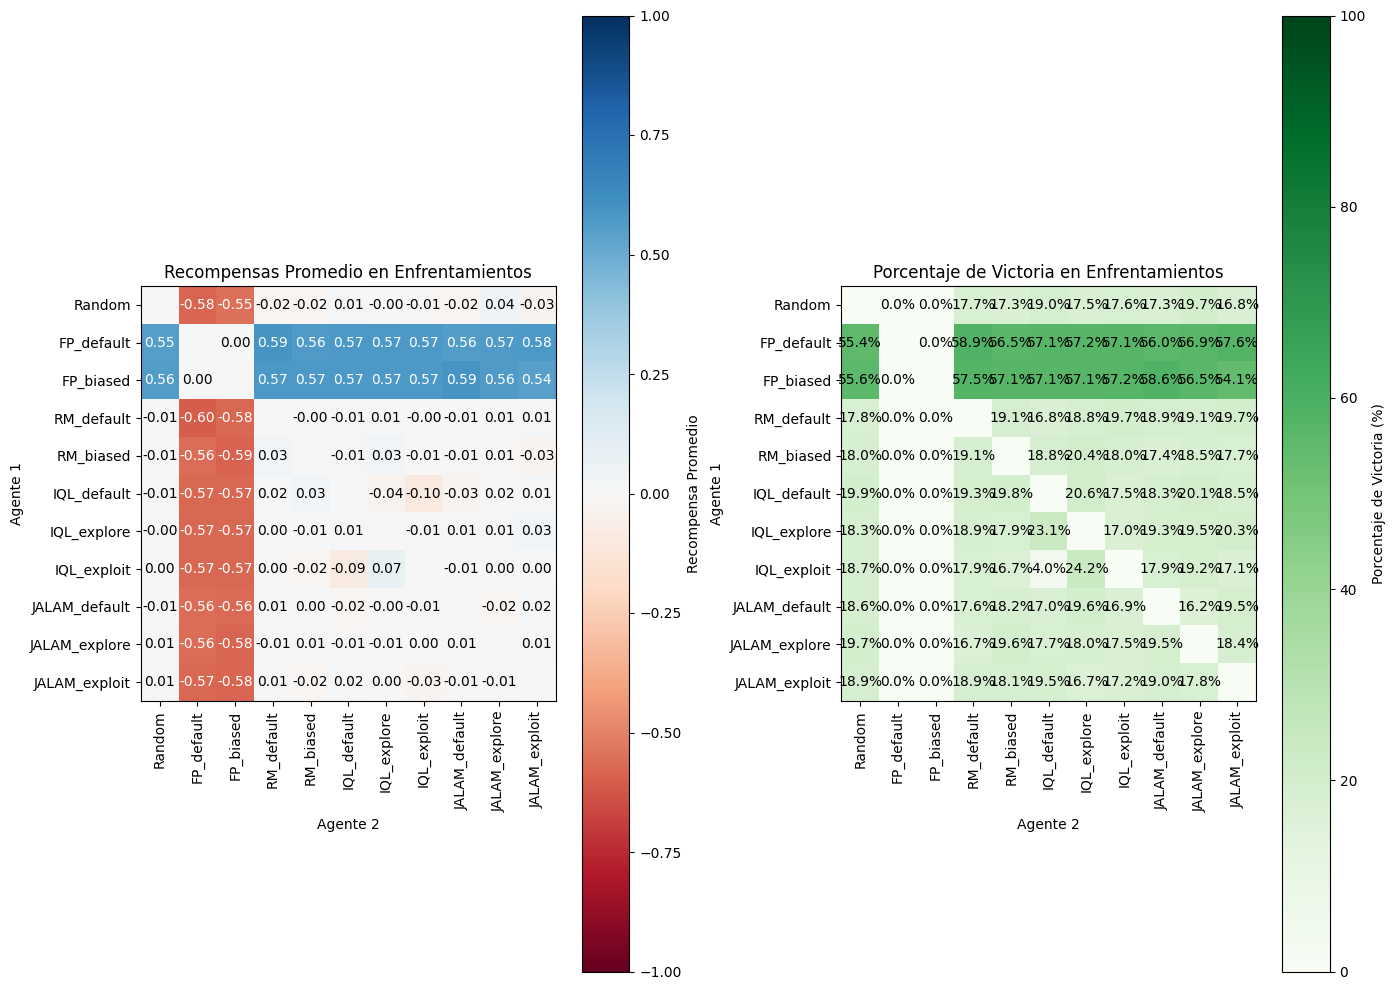

In [7]:
# Preparar matriz de recompensas y porcentajes de victoria para visualización
avg_reward_matrix = np.zeros((num_agents, num_agents))
win_percentage_matrix = np.zeros((num_agents, num_agents))

for i, agent1_name in enumerate(agent_names):
    for j, agent2_name in enumerate(agent_names):
        if i == j:
            avg_reward_matrix[i, j] = 0  # Diagonal: mismo agente vs. mismo agente
            win_percentage_matrix[i, j] = 0
        else:
            if agent2_name in results_matrix[agent1_name]:
                avg_reward_matrix[i, j] = results_matrix[agent1_name][agent2_name]["avg_reward"]
                win_percentage_matrix[i, j] = results_matrix[agent1_name][agent2_name]["win_percentage"]
            else:
                # Si el enfrentamiento no se realizó por alguna razón, usamos valores por defecto
                avg_reward_matrix[i, j] = 0
                win_percentage_matrix[i, j] = 0

# Visualizar matriz de recompensas promedio
plt.figure(figsize=(14, 10))
plt.subplot(1, 2, 1)
plt.imshow(avg_reward_matrix, cmap='RdBu', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(label='Recompensa Promedio')
plt.title('Recompensas Promedio en Enfrentamientos')
plt.xlabel('Agente 2')
plt.ylabel('Agente 1')
plt.xticks(np.arange(num_agents), agent_names, rotation=90)
plt.yticks(np.arange(num_agents), agent_names)

# Agregar valores numéricos a la matriz
for i in range(num_agents):
    for j in range(num_agents):
        if i != j:  # Solo mostrar valores donde hay enfrentamientos
            plt.text(j, i, f'{avg_reward_matrix[i, j]:.2f}', 
                    ha='center', va='center', 
                    color='white' if abs(avg_reward_matrix[i, j]) > 0.5 else 'black')

# Visualizar matriz de porcentajes de victoria
plt.subplot(1, 2, 2)
plt.imshow(win_percentage_matrix, cmap='Greens', interpolation='nearest', vmin=0, vmax=100)
plt.colorbar(label='Porcentaje de Victoria (%)')
plt.title('Porcentaje de Victoria en Enfrentamientos')
plt.xlabel('Agente 2')
plt.ylabel('Agente 1')
plt.xticks(np.arange(num_agents), agent_names, rotation=90)
plt.yticks(np.arange(num_agents), agent_names)

# Agregar valores numéricos a la matriz
for i in range(num_agents):
    for j in range(num_agents):
        if i != j:  # Solo mostrar valores donde hay enfrentamientos
            plt.text(j, i, f'{win_percentage_matrix[i, j]:.1f}%', 
                    ha='center', va='center', 
                    color='black' if win_percentage_matrix[i, j] < 70 else 'white')

plt.tight_layout()
plt.show()

## 8. Resumen de victorias totales por agente

Calculamos un resumen mostrando el número total de victorias y derrotas para cada agente.

Resumen de rendimiento por agente:
Agente          Victorias  Derrotas   Empates    % Victoria Reward    
-----------------------------------------------------------------
FP_default      18         0          2          51.27      +0.51     
FP_biased       18         0          2          51.08      +0.51     
IQL_exploit     11         8          1          13.57      -0.12     
IQL_default     9          11         0          15.40      -0.12     
JALAM_default   9          11         0          14.36      -0.12     
IQL_explore     8          11         1          15.43      -0.11     
RM_biased       8          12         0          14.79      -0.11     
JALAM_explore   7          13         0          14.71      -0.11     
Random          7          12         1          14.29      -0.12     
JALAM_exploit   6          14         0          14.61      -0.12     
RM_default      5          14         1          14.99      -0.12     


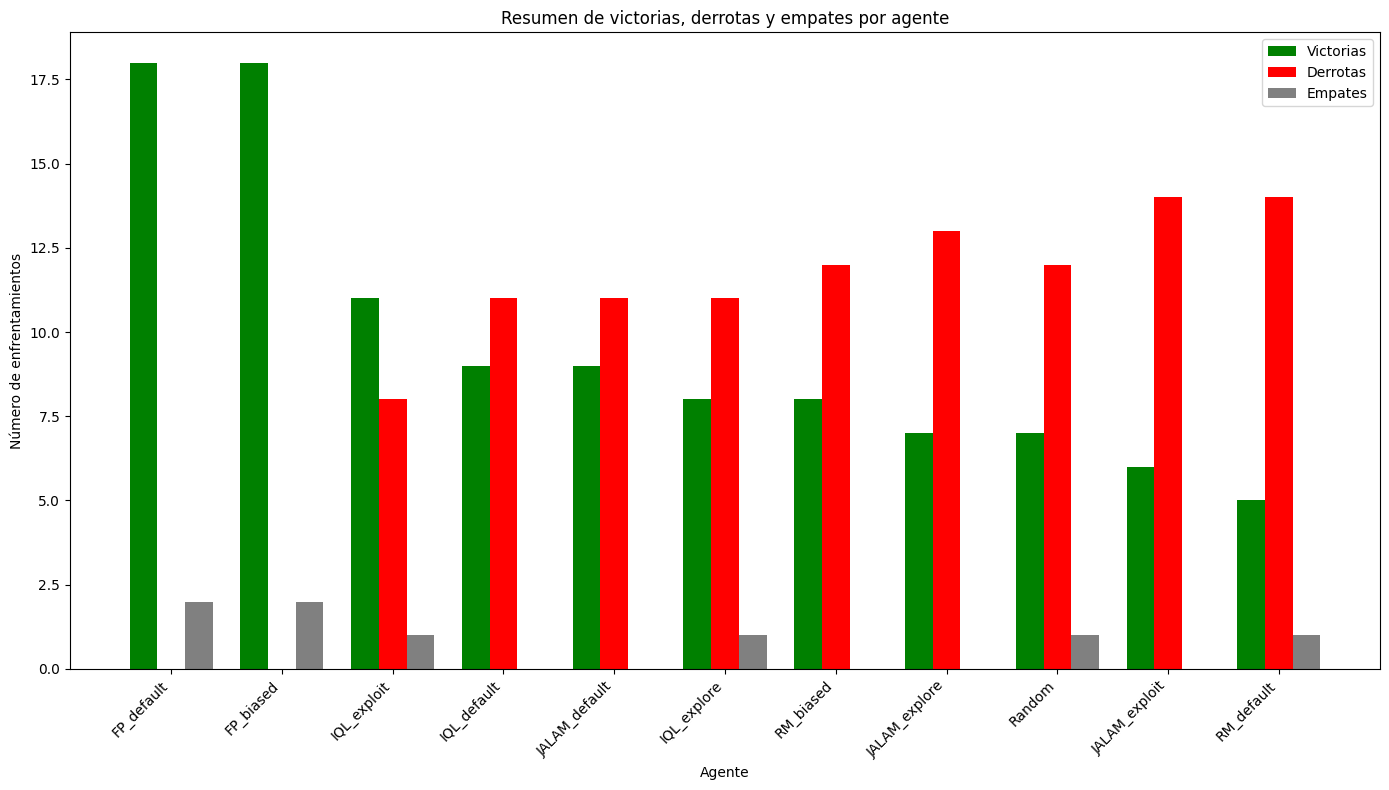

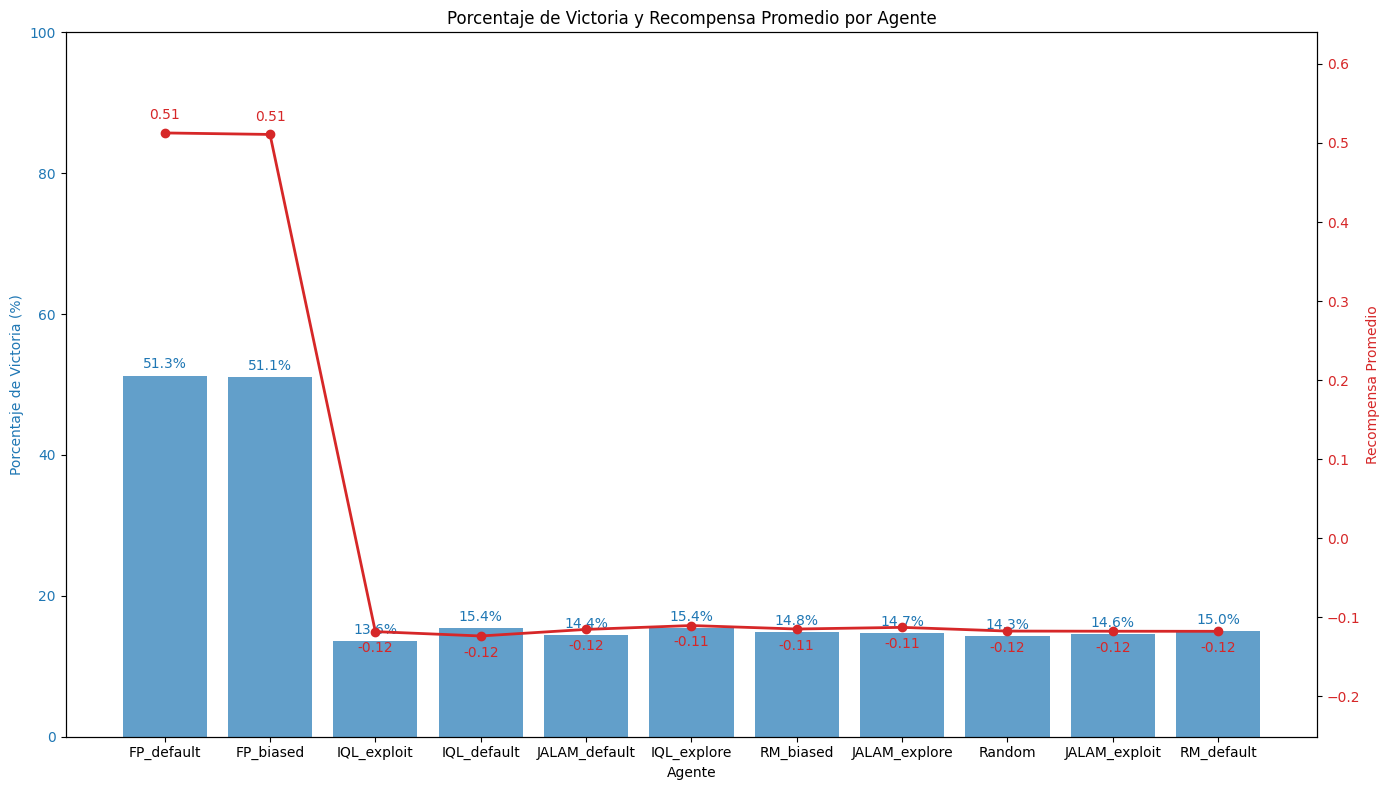

In [8]:
# Calcular victorias, derrotas, empates y rendimiento general para cada agente
summary = {agent_name: {"wins": 0, "losses": 0, "draws": 0, "avg_reward": 0, "avg_win_percentage": 0} for agent_name in agent_names}

for agent1_name in agent_names:
    total_matches = 0
    total_reward = 0
    total_win_percentage = 0
    
    for agent2_name in agent_names:
        if agent1_name == agent2_name:
            continue
            
        if agent2_name in results_matrix[agent1_name]:
            result = results_matrix[agent1_name][agent2_name]
            total_reward += result["avg_reward"]
            total_win_percentage += result["win_percentage"]
            
            if result["winner"] == "Agent1":
                summary[agent1_name]["wins"] += 1
                summary[agent2_name]["losses"] += 1
            elif result["winner"] == "Agent2":
                summary[agent1_name]["losses"] += 1
                summary[agent2_name]["wins"] += 1
            else:  # Empate
                summary[agent1_name]["draws"] += 1
                summary[agent2_name]["draws"] += 1
            
            total_matches += 1
    
    if total_matches > 0:
        summary[agent1_name]["avg_reward"] = total_reward / total_matches
        summary[agent1_name]["avg_win_percentage"] = total_win_percentage / total_matches

# Ordenar agentes por número de victorias
sorted_agents = sorted(agent_names, key=lambda x: (summary[x]["wins"], summary[x]["avg_win_percentage"]), reverse=True)

# Mostrar tabla de resumen
print("Resumen de rendimiento por agente:")
print(f"{'Agente':<15} {'Victorias':<10} {'Derrotas':<10} {'Empates':<10} {'% Victoria':<10} {'Reward':<10}")
print("-" * 65)

for agent_name in sorted_agents:
    s = summary[agent_name]
    print(f"{agent_name:<15} {s['wins']:<10d} {s['losses']:<10d} {s['draws']:<10d} {s['avg_win_percentage']:<10.2f} {s['avg_reward']:<+10.2f}")

# Visualizar el resumen en un gráfico de barras
plt.figure(figsize=(14, 8))

# Crear gráfico de barras para victorias, derrotas y empates
bar_width = 0.25
index = np.arange(len(sorted_agents))

plt.bar(index, [summary[agent]["wins"] for agent in sorted_agents], bar_width, label='Victorias', color='green')
plt.bar(index + bar_width, [summary[agent]["losses"] for agent in sorted_agents], bar_width, label='Derrotas', color='red')
plt.bar(index + bar_width * 2, [summary[agent]["draws"] for agent in sorted_agents], bar_width, label='Empates', color='gray')

plt.xlabel('Agente')
plt.ylabel('Número de enfrentamientos')
plt.title('Resumen de victorias, derrotas y empates por agente')
plt.xticks(index + bar_width, sorted_agents, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Visualizar porcentaje de victoria y recompensa promedio
fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Agente')
ax1.set_ylabel('Porcentaje de Victoria (%)', color=color)
bars = ax1.bar(sorted_agents, [summary[agent]["avg_win_percentage"] for agent in sorted_agents], color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 100])  # Porcentaje de 0 a 100%

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', color=color)

# Crear segundo eje para la recompensa promedio
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Recompensa Promedio', color=color)
line = ax2.plot(sorted_agents, [summary[agent]["avg_reward"] for agent in sorted_agents], 'o-', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
# Establecer el límite en función del rango de recompensas
reward_min = min([summary[agent]["avg_reward"] for agent in sorted_agents])
reward_max = max([summary[agent]["avg_reward"] for agent in sorted_agents])
margin = (reward_max - reward_min) * 0.2  # Agregar un margen del 20%
ax2.set_ylim([reward_min - margin, reward_max + margin])

# Agregar etiquetas de valores para los puntos de la línea
for i, agent in enumerate(sorted_agents):
    avg_reward = summary[agent]["avg_reward"]
    ax2.annotate(f'{avg_reward:.2f}',
                xy=(i, avg_reward),
                xytext=(0, 10 if avg_reward > 0 else -15),  # Ajustar offset vertical
                textcoords="offset points",
                ha='center', color=color)

plt.title('Porcentaje de Victoria y Recompensa Promedio por Agente')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
plt.show()

## 9. Análisis de distribuciones de soldados

Para entender mejor las estrategias, analizamos qué distribuciones de soldados prefiere cada agente.

Analizando estrategias preferidas de soldados para cada agente...

Top 5 estrategias para Random:
  1. Distribución [1, 1, 1, 1, 6] (Probabilidad: 19.00%)
  2. Distribución [2, 2, 2, 2, 2] (Probabilidad: 17.00%)
  3. Distribución [1, 1, 2, 3, 3] (Probabilidad: 16.00%)
  4. Distribución [1, 1, 1, 2, 5] (Probabilidad: 16.00%)
  5. Distribución [1, 2, 2, 2, 3] (Probabilidad: 14.00%)

Top 5 estrategias para FP_default:
  1. Distribución [2, 2, 2, 2, 2] (Probabilidad: 100.00%)
  2. Distribución [1, 2, 2, 2, 3] (Probabilidad: 0.00%)
  3. Distribución [1, 1, 2, 3, 3] (Probabilidad: 0.00%)
  4. Distribución [1, 1, 2, 2, 4] (Probabilidad: 0.00%)
  5. Distribución [1, 1, 1, 3, 4] (Probabilidad: 0.00%)

Top 5 estrategias para RM_default:
  1. Distribución [1, 1, 1, 1, 6] (Probabilidad: 20.00%)
  2. Distribución [1, 1, 1, 2, 5] (Probabilidad: 19.00%)
  3. Distribución [1, 2, 2, 2, 3] (Probabilidad: 18.00%)
  4. Distribución [1, 1, 2, 2, 4] (Probabilidad: 15.00%)
  5. Distribución [1, 1, 1, 3, 4] (

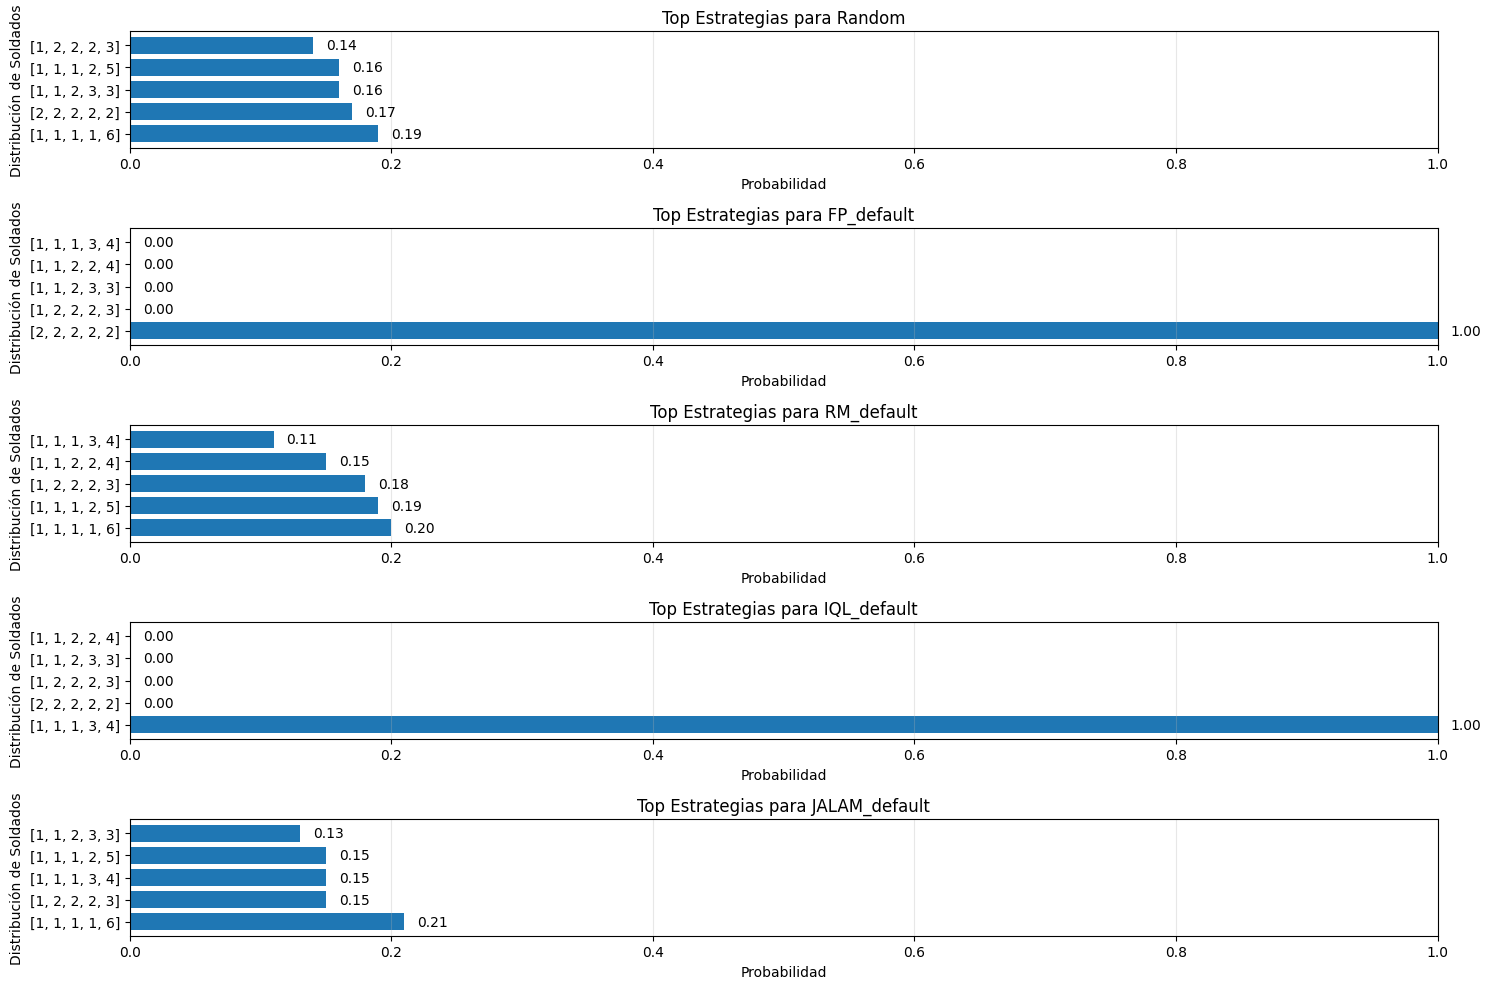

In [9]:
# Seleccionar algunos agentes representativos para analizar sus estrategias
agents_to_analyze = ["Random", "FP_default", "RM_default", "IQL_default", "JALAM_default"]
num_games_analysis = 100  # Número de juegos para análisis
strategy_counts = {agent_name: {} for agent_name in agents_to_analyze}

# Crear un nuevo juego para el análisis de estrategias
strategy_game = Blotto(S=10, N=5)

print("Analizando estrategias preferidas de soldados para cada agente...")

for agent_name in agents_to_analyze:
    agent = agents_pool[agent_name]
    
    # Recopilar distribuciones utilizadas
    action_counts = np.zeros(strategy_game.action_spaces[strategy_game.agents[0]].n)
    
    for _ in range(num_games_analysis):
        strategy_game.reset()
        if hasattr(agent, 'reset'):
            agent.reset()
        
        action = agent.action()
        action_counts[action] += 1
    
    # Normalizar para obtener probabilidades
    action_probs = action_counts / num_games_analysis
    
    # Guardar las 5 estrategias más utilizadas
    top_actions_indices = np.argsort(action_probs)[-5:][::-1]
    strategy_counts[agent_name] = {
        "indices": top_actions_indices,
        "probs": action_probs[top_actions_indices],
        "distributions": [strategy_game._moves[i] for i in top_actions_indices]
    }
    
    print(f"\nTop 5 estrategias para {agent_name}:")
    for i, (action_idx, prob) in enumerate(zip(top_actions_indices, action_probs[top_actions_indices])):
        print(f"  {i+1}. Distribución {strategy_game._moves[action_idx]} (Probabilidad: {prob:.2%})")

# Visualizar las estrategias preferidas
plt.figure(figsize=(15, 10))

num_agents_to_plot = len(agents_to_analyze)
num_strategies_to_plot = min(5, max([len(strategy_counts[agent]["indices"]) for agent in agents_to_analyze]))

for i, agent_name in enumerate(agents_to_analyze):
    plt.subplot(num_agents_to_plot, 1, i+1)
    
    indices = strategy_counts[agent_name]["indices"][:num_strategies_to_plot]
    probs = strategy_counts[agent_name]["probs"][:num_strategies_to_plot]
    distributions = strategy_counts[agent_name]["distributions"][:num_strategies_to_plot]
    
    # Crear etiquetas más legibles para las distribuciones
    labels = [f"[{', '.join(map(str, d))}]" for d in distributions]
    
    plt.barh(range(len(indices)), probs, align='center')
    plt.yticks(range(len(indices)), labels)
    plt.xlabel('Probabilidad')
    plt.ylabel('Distribución de Soldados')
    plt.title(f'Top Estrategias para {agent_name}')
    plt.xlim([0, 1])
    plt.grid(axis='x', alpha=0.3)
    
    # Agregar valores numéricos
    for j, v in enumerate(probs):
        plt.text(v + 0.01, j, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()

## 10. Conclusiones Clave y Superioridad de Fictitious Play

Tras el análisis de los enfrentamientos en Blotto (S=10, N=5), la observación principal es el **rendimiento consistentemente superior de los agentes Fictitious Play (FP)** en comparación con otras estrategias como Regret Matching, IQL y JAL-AM.

Las posibles razones de esta superioridad incluyen:

1.  **Convergencia Efectiva en Blotto**:
    *   FP está diseñado para converger al Equilibrio de Nash en juegos de suma cero de dos jugadores. Blotto (S=10, N=5), aunque complejo, comparte características con estos juegos. Es probable que los agentes FP hayan logrado una aproximación más cercana a una estrategia de equilibrio, haciéndolos robustos contra diversos oponentes.
    *   *Observación específica del experimento: [Añade aquí si los gráficos de recompensa/victoria de FP muestran estabilidad o una clara ventaja sobre el resto].*

2.  **Modelado Implícito del Oponente**:
    *   FP aprende jugando la mejor respuesta a la estrategia histórica promedio del oponente. En un juego con un espacio de acciones tan grande como Blotto (1001 acciones posibles), esta aproximación parece haber sido más eficaz para identificar y explotar patrones o tendencias en las estrategias de los oponentes, incluso si estos también estaban aprendiendo.
    *   *Observación específica del experimento: [Añade aquí si FP mostró una ventaja particular contra agentes más predecibles o menos adaptativos].*

3.  **Robustez en Espacios de Acciones Grandes**:
    *   A diferencia de IQL o JAL-AM, que pueden requerir una exploración exhaustiva y un ajuste fino de hiperparámetros para navegar eficazmente el vasto espacio de acciones de Blotto (S=10, N=5), FP podría haber encontrado políticas sólidas de manera más directa. Los agentes de RL podrían haber luchado por generalizar o evitar óptimos locales con el volumen de entrenamiento dado.
    *   *Observación específica del experimento: [Compara el rendimiento de las variantes de IQL/JALAM (explore, exploit, default) con FP. ¿Mostraron los agentes RL dificultades para superar a FP consistentemente?].*

4.  **Naturaleza de las Estrategias en Blotto**:
    *   Las estrategias exitosas en Blotto a menudo implican distribuciones de recursos difíciles de contraatacar consistentemente. El enfoque de FP, al promediar y responder, podría ser particularmente bueno para descubrir este tipo de distribuciones equilibradas y robustas.
    *   *Observación específica del experimento: [Analiza las distribuciones de soldados preferidas por FP (celda 17). ¿Son notablemente diferentes o más efectivas que las de otros agentes?].*

En resumen, la capacidad de Fictitious Play para modelar la estrategia promedio del adversario y su tendencia a converger hacia políticas de equilibrio parecen haber sido factores decisivos para su éxito en esta configuración específica del juego Blotto. Los agentes de aprendizaje por refuerzo más complejos, aunque potentes, podrían haber necesitado más datos o un ajuste más específico para superar la eficacia de FP en este escenario.